Используйте базу акций Лукойла.

Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Примените абсолютно новый подход. Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).
* Объедините эти точки

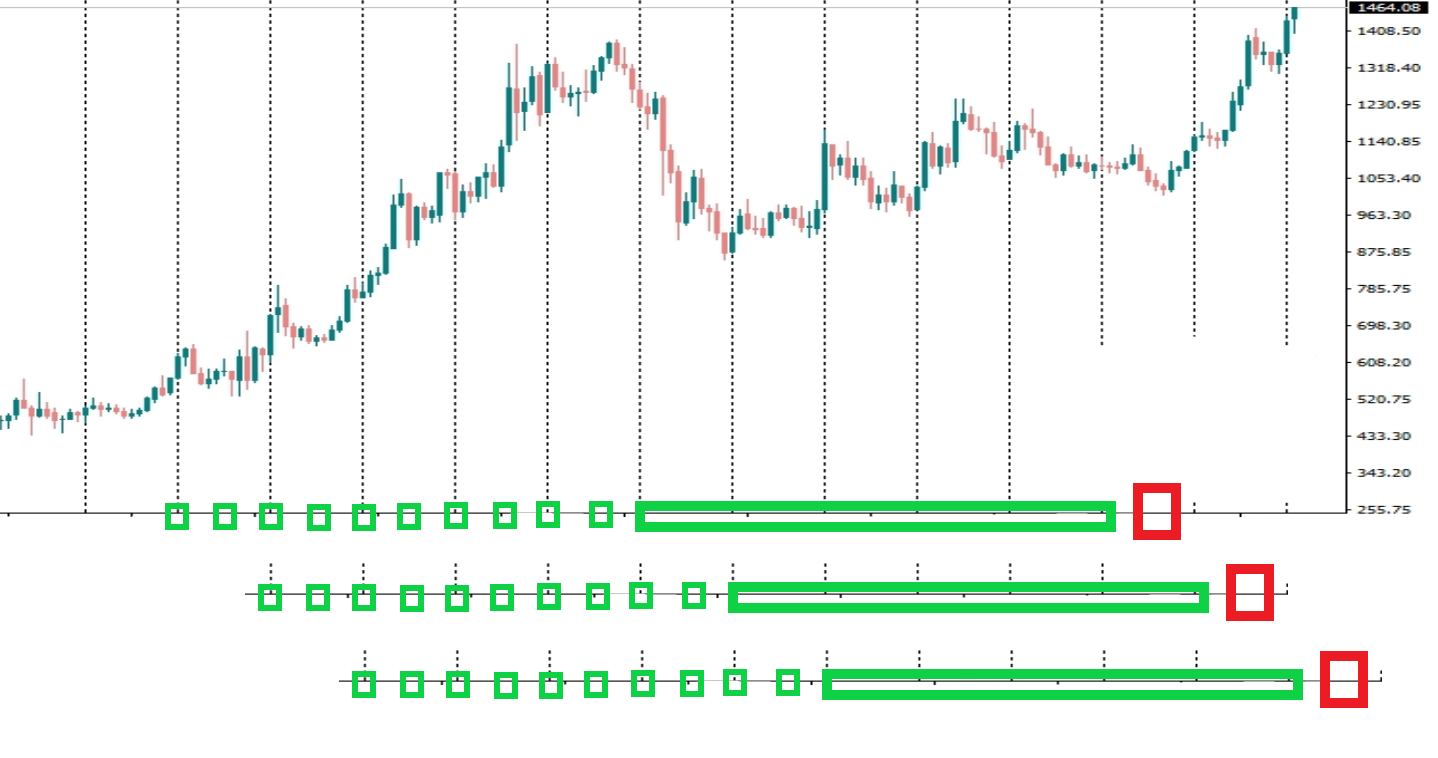

## Подготовка

In [5]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D, Concatenate

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

from pylab import rcParams
# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import acf

In [6]:
# Назначение размера и стиля графиков по умолчанию

plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [7]:
# Загрузка и предварительная обработка
data16_17 = pd.read_csv('/kaggle/input/data1617/16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('/kaggle/input/data1819/18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

print(data16_17.shape)
print(data18_19.shape)

# Объединение датасетов
data = pd.concat([data16_17, data18_19]).reset_index(drop=True)

# Проверка формы данных
print(data.shape)

# Выводим названия столбцов
col = data.columns
print(col)

(263925, 5)
(217947, 5)
(481872, 5)
Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


In [8]:
# Выбор только нужных базовых признаков
base_cols = ['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME']
data = data[base_cols].astype(np.float32)

# Добавим только простые производные (1-я и 2-я)
for col in base_cols:
    data[f'd_{col}'] = data[col].diff()
    data[f'd2_{col}'] = data[col].diff().diff()

# Удаление пропусков
data = data.dropna().reset_index(drop=True)

# Преобразование в массив
values = data.values.astype(np.float32)

In [9]:
# Нормализация
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

close_idx = base_cols.index('CLOSE')
X = np.hstack((values[:, :close_idx], values[:, close_idx+1:]))
y = values[:, close_idx:close_idx+1]

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Последовательности
SEQ_SHORT, SEQ_LONG = 50, 50

In [10]:
def make_seq(data, steps, step_size):
    res = []
    for i in range(steps * step_size, len(data)):
        idx = [i - j * step_size for j in range(steps)][::-1]
        res.append(data[idx])
    return np.array(res, dtype=np.float32)

X1 = make_seq(X_scaled, SEQ_SHORT, 1)
X2 = make_seq(X_scaled, SEQ_LONG, 10)
y_seq = y_scaled[SEQ_SHORT * 10:]

min_len = min(len(X1), len(X2), len(y_seq))
X1, X2, y_seq = X1[-min_len:], X2[-min_len:], y_seq[-min_len:]

In [11]:
# Создание модели
inp1 = Input(shape=(SEQ_SHORT, X1.shape[2]))
inp2 = Input(shape=(SEQ_LONG, X2.shape[2]))
x1 = Conv1D(16, 3, activation='relu')(inp1)
x2 = Conv1D(16, 3, activation='relu')(inp2)
x1 = Flatten()(x1)
x2 = Flatten()(x2)
x = Concatenate()([x1, x2])
x = Dense(64, activation='relu')(x)
out = Dense(1)(x)

model = Model([inp1, inp2], out)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Обучение
history = model.fit(
    [X1, X2], y_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

I0000 00:00:1748200917.991488      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 14)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 50, 14)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 48, 16)         │            688 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 48, 16)         │            688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 768)            │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 768)            │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1536)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │         49,184 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             33 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 50,593 (197.63 KB)

 Trainable params: 50,593 (197.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1748200926.970593      78 service.cc:148] XLA service 0x7b70d80095e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748200926.971157      78 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748200927.204508      78 cuda_dnn.cc:529] Loaded cuDNN version 90300


   74/27078 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0508 

I0000 00:00:1748200928.391543      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27078/27078 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 4.4910e-04 - val_loss: 1.5511e-05
Epoch 2/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 9.5201e-06 - val_loss: 9.1949e-04
Epoch 3/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 6.0202e-06 - val_loss: 4.6796e-06
Epoch 4/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 4.1011e-06 - val_loss: 1.3372e-04
Epoch 5/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 3.4226e-06 - val_loss: 2.6851e-06
Epoch 6/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 2.8032e-06 - val_loss: 2.3121e-06
Epoch 7/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 2.1942e-06 - val_loss: 3.0358e-05
Epoch 8/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 1.8877e-06 - val_loss: 3.7661e-06
Epoch 9/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 1.7942e-06 - val_loss: 1.3892e-06
Epoch 10/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 1.5283e-06 - val_loss: 1.4561e-06


In [14]:
def plot_learning_curve(history, title='График процесса обучения'):

    plt.figure(figsize=(14, 6))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Ошибка на валидации', color='orange')
    plt.title(title)
    plt.xlabel('Эпоха')
    plt.ylabel('Среднеквадратичная ошибка (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def eval_net(model, X1, X2, y_scaled, y_scaler, lags=50):
    """
    Оценка модели:
    - График предсказания vs факт
    - График корреляции ошибок по лагам
    """
    # Предсказания
    y_pred_scaled = model.predict([X1, X2], verbose=0)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_scaled)

    # График фактических vs прогнозных
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label='Факт', color='blue')
    plt.plot(y_pred, label='Прогноз', color='red', alpha=0.7)
    plt.title('Фактические и прогнозные значения')
    plt.xlabel('Временной шаг')
    plt.ylabel('CLOSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # График корреляции 
    def correlate(a, b):
        return np.corrcoef(a, b)[0, 1]

    steps = range(1, min(lags + 1, len(y_true) // 2))
    cross_corr = [correlate(y_true[:-s, 0], y_pred[s:, 0]) for s in steps]
    auto_corr = [correlate(y_true[:-s, 0], y_true[s:, 0]) for s in steps]

    plt.figure(figsize=(14, 6))
    plt.plot(steps, cross_corr, label='Прогноз vs Факт')
    plt.plot(steps, auto_corr, label='Автокорреляция факта')
    plt.title('Корреляция предсказаний и факта с лагами')
    plt.xlabel('Лаг')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.grid(True)
    plt.show()

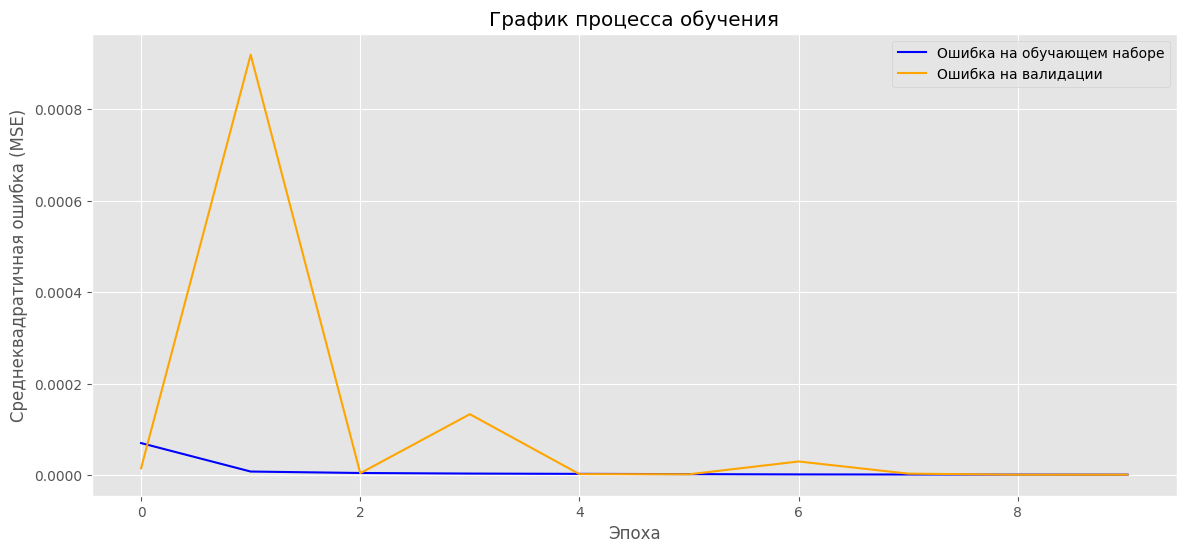

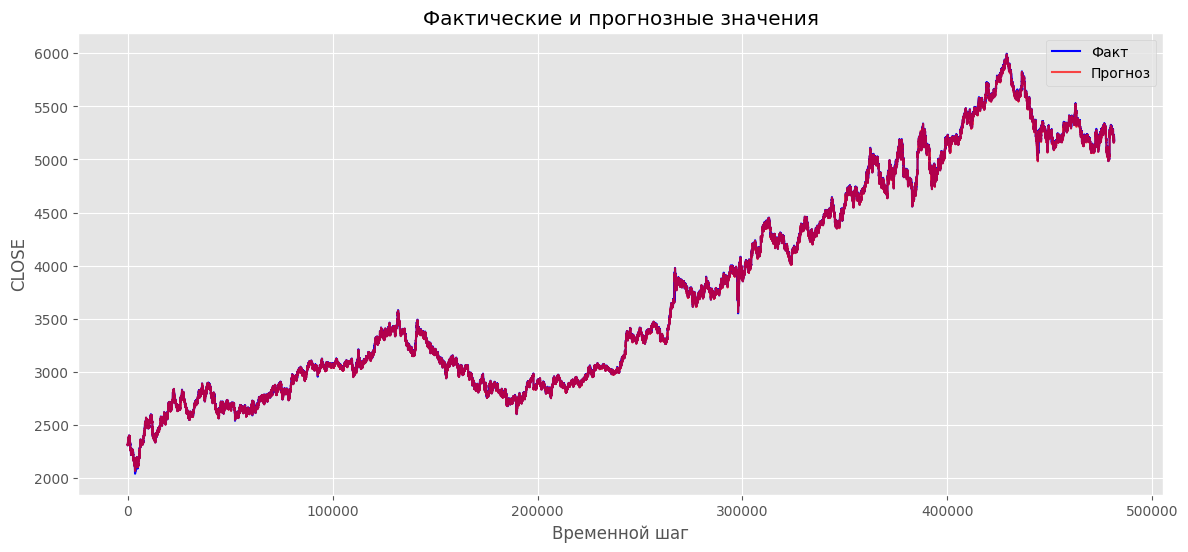

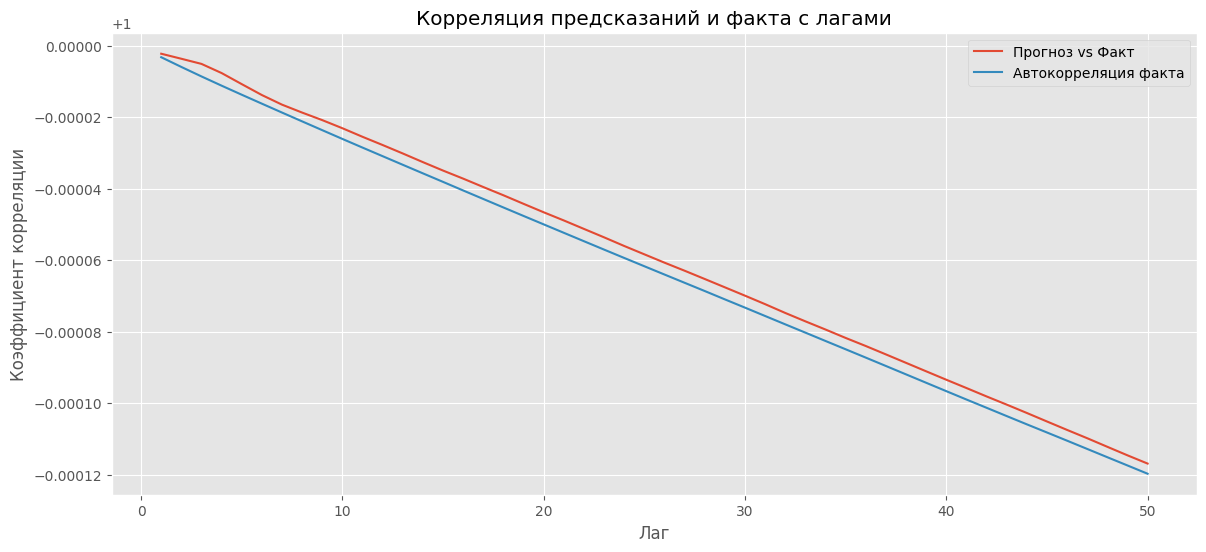

In [13]:
# График обучения
plot_learning_curve(history)
#Реальные и прогнозируемые значения
eval_net(model, X1, X2, y_seq, y_scaler)